# INTRO.

[DataFest Africa Noise Pollution Classification Challenge](https://zindi.africa/competitions/datafest-africa-2022) is a zindi Challenge.This is my starter notebook for audio classification. We'll preview the data, load in the data, train the model using FastAI Audio, make some predictions, improve predictions and also prepare submission to zindi.

# The Data
Looking into the data section on zindi, we find there 4 files. let's see the breakdown:
- Test.csv contains list of all test ausio file names and their unique ID
- Sample Submission contains the submission format, how it should look like.
- Train.csv contains the list of all train audio file names, labels and their unique ID including their respective labels.
- AUDIO_CLIPS.zip: This Zip file is about 11GB, it contains all the audio files in wav format 

There are ~ 30 000 audio files in train and ~12 000 audio files in test.

###### Mount your google colab drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

###### Copy contents to disk.

Yeah, I know, feels like i'm still wasting bandwidth though. I don't like working directly on my drive, I tend to copy the data to colab disk instead.

In [ ]:
!cp "/content/drive/MyDrive/machine_learning_stories/Noise Classification" -r "/content/"

###### Setup Fastai

In [ ]:
#pip install fastai --upgrade

###### setup fastaudio

Thanks to some community folks at Fastai Audio, It's basically an audio module for fastai v2. The intention was to help build audio machine learning applications while minimizing the need for audio domain expertise. Isn't that great! 🛫🚀

In [ ]:
pip install fastaudio

I basically just used exit to restart my notebook. There were dependency problems

In [ ]:
exit()

###### Import 

In [1]:
from torch.hub import load_state_dict_from_url
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *

#### The Idea

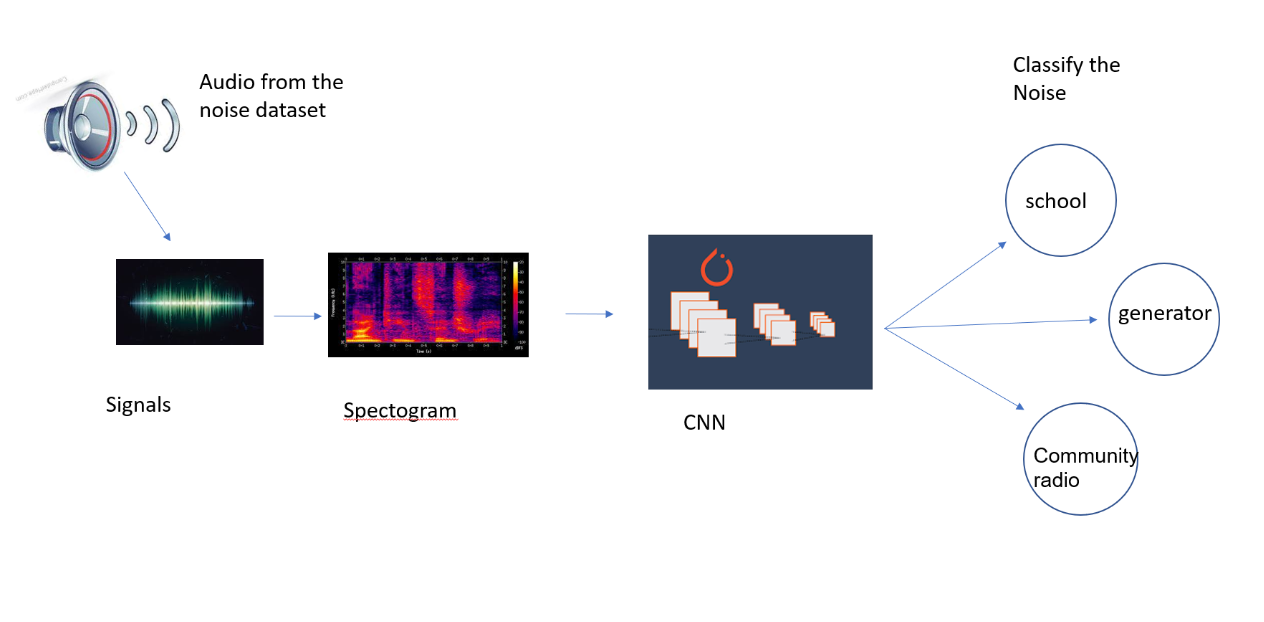

representing sound digitally is referred to as sampling, sampling simply created digital representation of the analog singal by taking measurements of the instantaneous amplitudes at spaced intervals.

Spectograms are actually very detailed and accurate images of these audio signals, it is usually depicted in form of a heatmap with intensiy shown by varying the color or brightness. you can check more on spectogram computation [here](https://www.mathworks.com/help/signal/ug/spectrogram-computation-in-signal-analyzer.html)

###### Setup your dataframe.
These are basic stuff, just load in your dataframe with the pandas library

In [15]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
#ss = pd.read_csv("/content/Noise Classification/SampleSubmission.csv")

In [30]:
ss = pd.read_csv("SampleSubmission.csv")

Take a peak at your Dataframe.

In [7]:
train.head()

,CLIP_ID,category
0,ID_RX0ERYVE,school
1,ID_RG7TUTFN,boda-boda-motocyle
2,ID_XQ2O77I0,bar-restaurant-nightclub
3,ID_K5G9YVJS,generator
4,ID_S2W5EPQP,community-radio


###### Set Seed.

We definitely don't want to be in the shoes of those not able to reproduce their score, so let's seed everything....

In [8]:
 def random_seed(seed_value, use_cuda): 
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value) 
# cpu  vars
    random.seed(seed_value)
 # Python 
    if use_cuda: 
        torch.cuda.manual_seed(seed_value) 
        torch.cuda.manual_seed_all(seed_value) 
# gpu vars
        torch.backends.cudnn.deterministic = True 
 #needed
        torch.backends.cudnn.benchmark = False 
#Remember to use num_workers=0 when creating the DataBunch.

In [9]:
random_seed(2023,True)

Confirm that GPU is available

In [3]:
torch.cuda.is_available()

True

###### Simple unzip

This is just simply unzipping the image file

In [ ]:
# unzip the data file
!unzip '/content/Noise Classification/Audio_clips.zip'

I'm just simply appending the paths in front of the file name and ".wav" as a suffix so that the image ids column can contain paths to the image.

In [16]:
train["CLIP_ID"] = ["./AUDIO_CLIPS/" + i +".wav" for i in train["CLIP_ID"]]

##### Let Fastai do all the work

FastAI audio has some built in collection of configurations to build the Audio-to-spec Transforms. The voice configs have the most intense sampling rate and nfft(length of the windowed signal after padding with zeros).

In [11]:
cfg = AudioConfig.Voice() # pull up the voice config
aud2spec = AudioToSpec.from_cfg(cfg) # let audio to spec use the config

In [12]:
cfg.f_max, cfg.sample_rate

(8000.0, 16000)

###### Quick show

Pipeline the flow from leveraging Fastcore's transformation functions do a quick show

In [19]:
pipe = Pipeline([AudioTensor.create, aud2spec])

Peep at the dataframe

In [21]:
train.head(2)

,CLIP_ID,category
0,./AUDIO_CLIPS/ID_RX0ERYVE.wav,school
1,./AUDIO_CLIPS/ID_RG7TUTFN.wav,boda-boda-motocyle


Let's check out what the pipeline is ddoing under the hood...

RAW AUDIO---------> SAMPLED SIGNAL--------------> SPECTOGRAM IMAGE

In [ ]:
for fn in train["CLIP_ID"][:3].values:
  print(fn)
  audio = AudioTensor.create(fn)
  audio.show()
  pipe(fn).show()

# Building Data loader

Use Fastai Data Api block to load the dataset, note that I used a stratified split for train and validation. You'll also have to notify fastai that you'll be using the AudioBlock, This block allows for the Audio Transformations & configs you want to use, enabling you to convert to spectograms on the fly

In [21]:
audio = DataBlock(blocks=(AudioBlock, CategoryBlock),
                      splitter=TrainTestSplitter(0.1, stratify=train["category"]),
                      get_x = ColReader(0),
                      get_y=ColReader(1),
                      item_tfms = [ResizeSignal(1000), aud2spec],
    )

Next here, we create the dataloader, I used a very small batch of 64 here, you might want to go higher or lower depending on your GPU resource, I'm using the Colab PRO which works fine for this batch size.

In [22]:
dls = audio.dataloaders(train,bs=64,num_workers = 0)

# Modelling & Training.

the audio files have a single channel (check out mono vs stereo), we'll  need to adjust the model's input to take in one channel. It's also interesting to know that the color in your spectogram is just an aesthetic, a grayscale spectogram has all the relevant information in it's pixel intensities. You can try out grayscale spectograms, see if there's any difference.

###### Adjust learner's input

In [23]:
def alter_learner(learn, n_channels=1):
  "Adjust a `Learner`'s model to accept `1` channel"
  layer = learn.model[0][0]
  layer.in_channels=n_channels
  layer.weight = nn.Parameter(layer.weight[:,1,:,:].unsqueeze(1))
  learn.model[0][0] = layer

Pull up Fastai's CNN xresnet18 as your baseline

In [24]:
learn = Learner(dls, xresnet18(), CrossEntropyLossFlat(), metrics=accuracy)

Check out a batch

In [ ]:
dls.show_batch(max_n=3)

to be sure, Confirm that we have a mono, where number of channels is 1

In [26]:
n_c = dls.one_batch()[0].shape[1]; n_c

1

Adjust learner to take in 1-channel as input

In [27]:
alter_learner(learn, n_c)

check out what changing the learning rate looks like.

SuggestedLRs(valley=0.0020892962347716093)

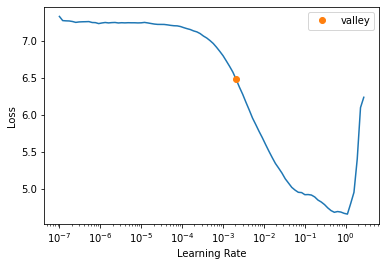

In [28]:
learn.lr_find()

###### Time to Train!!!

I'm not using a pretrained model, so I can't fine tune anything. You can use the fit_one_cycle to leverage Adams's optimizer or even the fit_flat_cos to use the ranger optimizer.

In [29]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.910220,1.728691,0.482044,05:36
1,1.405499,1.534400,0.539710,05:12
2,1.231679,1.257680,0.620166,05:18
3,1.082289,1.129438,0.660221,05:13
4,0.966419,1.018481,0.688881,05:15
5,0.913627,0.881232,0.735152,05:16
6,0.793821,0.843745,0.749309,05:15
7,0.739191,0.768304,0.763467,05:15
8,0.702257,0.749045,0.772445,05:19
9,0.670740,0.766379,0.770028,05:19


# Inference

Peep at the head of the test set

In [31]:
test.head()

,CLIP_ID
0,ID_552CT8A9
1,ID_HRMH24NR
2,ID_NOUBSOWH
3,ID_4CQI5UTV
4,ID_CRENUL8M


###### Prepare for Predictions

I also need to change the filename to path so that the dataloader can load it in smoothly.

In [32]:
test["CLIP_ID"] = ["./AUDIO_CLIPS/" + i +".wav" for i in test["CLIP_ID"]]

Leverage TTA.

In [33]:
tdl = learn.dls.test_dl(test["CLIP_ID"]) # quicly create test data loader
test_preds_tta, test_labels_tta = learn.tta(dl=tdl)

Check out what the head looks like

In [34]:
ss.head()

,CLIP_ID,category
0,ID_552CT8A9,NaN
1,ID_HRMH24NR,NaN
2,ID_NOUBSOWH,NaN
3,ID_4CQI5UTV,NaN
4,ID_CRENUL8M,NaN


In [35]:
preds_test = test_preds_tta

Pull out the predictions and save to your sample submission

In [36]:
class_list = learn.dls.vocab
class_indexes = np.argmax(preds_test, axis=1)
classes = [class_list[idx] for idx in class_indexes]

In [37]:
ss["category"] = classes

In [38]:
ss.head()

,CLIP_ID,category
0,ID_552CT8A9,boda-boda-motocyle
1,ID_HRMH24NR,boda-boda-motocyle
2,ID_NOUBSOWH,bar-restaurant-nightclub
3,ID_4CQI5UTV,boda-boda-motocyle
4,ID_CRENUL8M,car-or-truck


# Submit to Zindi.

In [40]:
name = "baseline.csv"
ss.to_csv(name, index=False)

This Challenge is pretty easy, with this starter notebook, I've approached a public score of ~ 0.9 with little or no work done. you could try out more stuff.


- Try the MelSpectogram instead of the Voice config.
- Use pretrained models- why would you not use a pretrained model?
 Augument Audio.
- Clean the data: we didn't do much data exploration here but you can. good data = good models.
- Convert images to spectograms first then classify with 3 channels.